# TensorFlow・Kerasのトレーニング♨

## DNN 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [プロキシ設定](#プロキシ設定)
  - [共通関数](#共通関数)
- [DNNアルゴリズム・モデル](#)
  - [DNNで重回帰分析](#DNNで重回帰分析)
  - [DNNの２クラス分類器](#DNNの２クラス分類器)
  - [DNNの多クラス分類器](#DNNの多クラス分類器)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python - DL  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python%20-%20DL

## [環境準備](TensorFlowAndKeras0.ipynb)

### インポート

In [ ]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
print(tf.__version__)

import keras
print(keras.__version__)
# モデル定義
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, Input, Activation, Flatten, Dropout, LSTM
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import SGD, Adam
# その他
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### プロキシ設定

In [2]:
import os
proxies = {
    "http": os.getenv("HTTP_PROXY"),
    "https": os.getenv("HTTPS_PROXY")
}

### 共通関数

#### [分類問題のメトリック表示関数](ScikitLearnTraining5.ipynb)

In [3]:
def print_metrics(label, pred):
    print('accuracy: %.3f' % metrics.accuracy_score(label, pred)) # 正答率
    
    print('\nmicro') # ミクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='micro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='micro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='micro')) # f値
    
    print('\nmacro') # マクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='macro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='macro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='macro')) # f値

#### 学習履歴表示関数

##### 損失

In [4]:
def plot_history_loss(hist):
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

###### 平均絶対値誤差

In [5]:
def plot_history_mae(hist):
    plt.plot(hist.history['mae'],label="mae for training")
    plt.plot(hist.history['val_mae'],label="mae for validation")
    plt.title('model mae')
    plt.xlabel('epoch')
    plt.ylabel('mae')
    plt.legend(loc='best')
    plt.show()

##### 正解率

In [6]:
def plot_history_acc(hist):
    plt.plot(hist.history['accuracy'],label="accuracy for training")
    plt.plot(hist.history['val_accuracy'],label="accuracy for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

## DNNアルゴリズム・モデル

### DNNで重回帰分析

#### データ

##### 生成
[重回帰分析](ScikitLearnTraining1.ipynb)で使用したデータを使用。

In [7]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=Boston.csv&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_csv(io.BytesIO(res.content), encoding='utf-8', sep=",")
df

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,505,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


##### 加工

In [8]:
df=df.drop('Unnamed: 0',axis=1)

##### 理解
...

##### 準備

###### 説明変数・目的変数の選択・分割

In [9]:
x_org = np.array(df.drop(['medv'], axis=1))
y_org = np.array(df.loc[:, ['medv']])

###### 正規化
axis=0で列単位（変数単位）。

In [10]:
mean = x_org.mean(axis=0)
std = x_org.std(axis=0)
x = (x_org - mean) / std

###### 学習・テストデータの分割（ホールド・アウト法

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y_org, test_size = 0.3, random_state = 0)

#### モデリング

##### DNNの定義
- 入力層  
入力ベクトルの要素数だけ。
- 隠れ層が
  - 2つ
  - 64ノードづつ
  - 活性化関数はrelu
- 出力層  
回帰なので活性化関数は恒等関数 ≒ 無し

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

##### コンパイル
- 回帰の損失関数は誤差二乗和（mse ≒ mean_squared_error）
- [optimizer=Adam](TensorFlowAndKeras0.ipynb)を指定する。
- metricsは平均絶対誤差（mae ≒ mean_absolute_error）

In [13]:
model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])

##### 確認

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

##### 実行

###### 学習

In [15]:
batch_size = 20
n_epoch = 200
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=n_epoch,
                 validation_data=(x_test, y_test),
                 verbose=0)

###### 推論

In [16]:
y_pred = model.predict(x)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


##### 評価

###### 実測・予測を表示

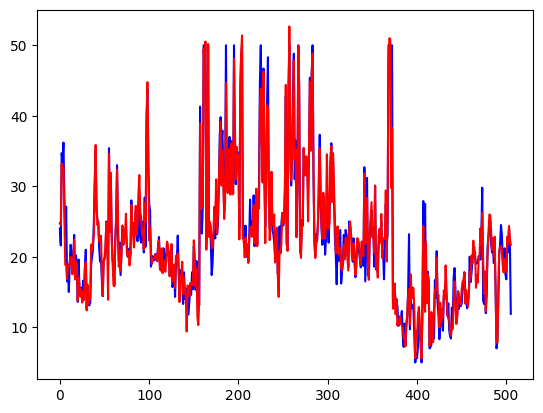

In [17]:
plt.plot(y_org, color='blue') # 実測値
plt.plot(y_pred, color='red') # 予測値
plt.show()

###### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
- 平均絶対誤差（MAE：Mean Absolute Error）
- 平均二乗誤差（MSE：Mean Squared Error）

In [18]:
# sklearnで
from sklearn.metrics import mean_squared_error as mse

train_mse = mse(y_train, model.predict(x_train))
test_mse = mse(y_test, model.predict(x_test))

print('train_mse: %.3f' % train_mse)
print('test_mse: %.3f' % test_mse)
print('train_rmse: %.3f' % (train_mse ** (1/2)))
print('test_rmse : %.3f' % (test_mse ** (1/2)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
train_mse: 2.076
test_mse: 13.855
train_rmse: 1.441
test_rmse : 3.722


In [19]:
# metricsで
print(model.metrics_names)

['loss', 'compile_metrics']


In [20]:
score = model.evaluate(x, y_org, verbose=0)
print('mse:', score[0])
print('mae:', score[1])
print('rmae:', (score[0] ** (1/2)))

mse: 5.614453315734863
mae: 1.5216540098190308
rmae: 2.3694837656618084


In [21]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train mse:', train_score[0])
print('Train mae:', train_score[1])
print('Train rmae:', (train_score[0] ** (1/2)))

Train mse: 2.076319694519043
Train mae: 1.0529730319976807
Train rmae: 1.4409440289334776


In [22]:
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test mse:', test_score[0])
print('Test mae:', test_score[1])
print('Test rmae:', (test_score[0] ** (1/2)))

Test mse: 13.854580879211426
Test mae: 2.6131865978240967
Test rmae: 3.7221742139791663


###### 学習履歴を表示

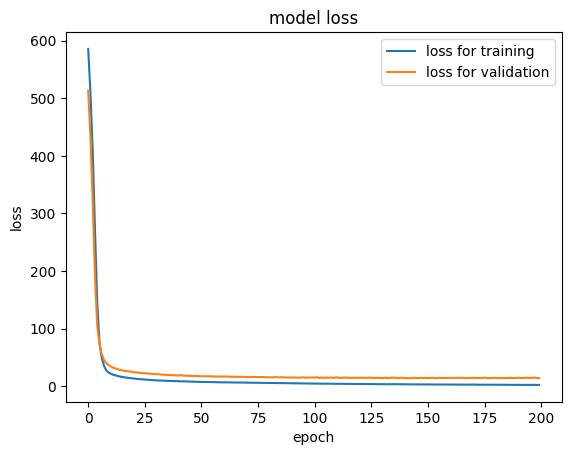

In [23]:
plot_history_loss(hist)

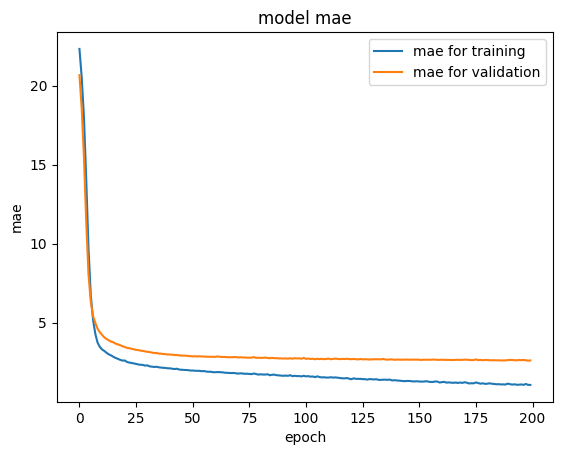

In [24]:
plot_history_mae(hist)

### DNNの２クラス分類器

#### データ

##### 生成

###### ダウンロードしてDFに読込

In [25]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=diabetes.csv&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_csv(io.BytesIO(res.content), encoding='utf-8', sep=",")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


###### [説明を参照](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20DataSet#j443d0cb)

In [26]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

##### 加工
...

##### 理解

In [27]:
# 基本統計量
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [28]:
# 相関係数（相関行列）
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


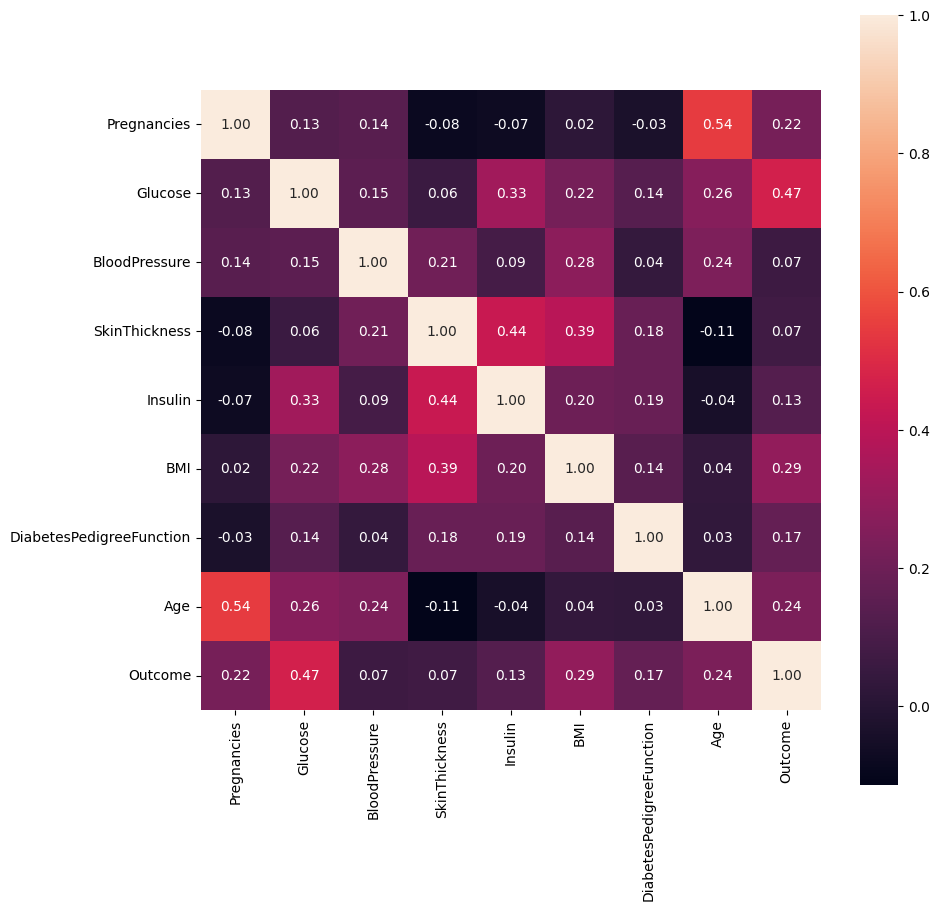

In [29]:
# ヒートマップに表示
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

In [30]:
# 散布図行列を表示
#sns.pairplot(df, hue='Outcome')

##### 準備

###### 説明変数・目的変数の選択・分割

In [31]:
x_org = np.array(df.loc[:, ['Pregnancies','Glucose','BMI', 'Age']])
y_org = np.array(df.loc[:, ['Outcome']])

###### 標準化

In [32]:
ss = StandardScaler()
x = ss.fit_transform(x_org)

# 確認
## 平均が ≒ 0
print("x.mean(): ", x.mean())
## 標準偏差が ≒ 1
print("x.std(): ", x.std())

x.mean():  9.454242944073599e-17
x.std():  1.0


###### 学習・テストデータの分割（ホールド・アウト法

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y_org, test_size = 0.3, random_state = 0)

#### モデリング

##### DNNの定義
- 入力層  
入力ベクトルの要素数だけ。
- 隠れ層が
  - 2つ
  - 64ノードづつ
  - 活性化関数はrelu
- 出力層  
２クラス分類なので
  - ノードは１つ（0-1）
  - 活性化関数はsigmoid

In [34]:
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

##### コンパイル
- 2値分類の損失関数は二値交差エントロピー（binary_crossentropy）
- [optimizer=Adam](TensorFlowAndKeras0.ipynb)を指定する。
- metricsは正解率（accuracy）

In [35]:
# metricsにf1_score, precision, recallの評価関数を定義して指定することも可能
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

##### 確認

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

#### 実行

##### 学習

In [37]:
batch_size = 10
n_epoch = 200
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=n_epoch,
                 validation_data=(x_test, y_test),
                 verbose=0)

##### 推論

In [38]:
y_pred = model.predict(x)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


#### 評価

###### 実測・予測を表示

In [39]:
y_pred = np.array(np.round(y_pred), dtype=np.int64)
ret = (y_org == y_pred)
(len(np.where(ret==True)[0]) / ret.size)

0.8606770833333334

###### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)

In [40]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [41]:
score = model.evaluate(x, y_org, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

loss: 0.3580746352672577
accuracy: 0.8606770634651184


In [42]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

Train loss: 0.22636960446834564
Train accuracy: 0.9068901538848877


In [43]:
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.6642460823059082
Test accuracy: 0.7532467246055603


###### 混同行列

In [44]:
cm_minst = confusion_matrix(y_org, y_pred)
print(cm_minst.dtype)
print(cm_minst)

int64
[[468  32]
 [ 75 193]]


In [45]:
print_metrics(y_org, y_pred)

accuracy: 0.861

micro
recall: 0.861
precision: 0.861
f1_score: 0.861

macro
recall: 0.828
precision: 0.860
f1_score: 0.840


###### 学習履歴を表示
- 表現力が高過ぎるので、がっつり過学習している。
- [過学習を抑止してスコアが上がるかどうか？](https://qiita.com/hiroyuki827/items/213146d551a6e2227810)

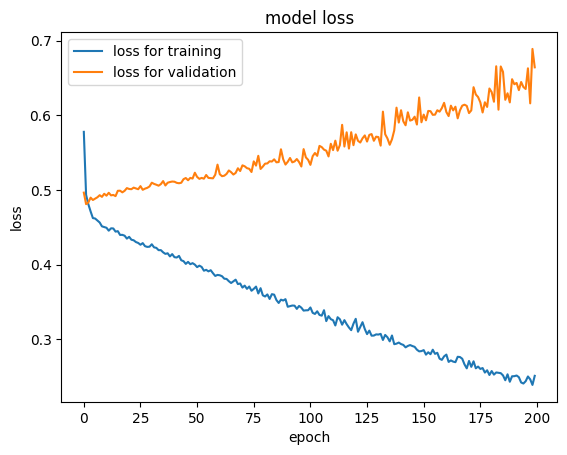

In [46]:
plot_history_loss(hist)

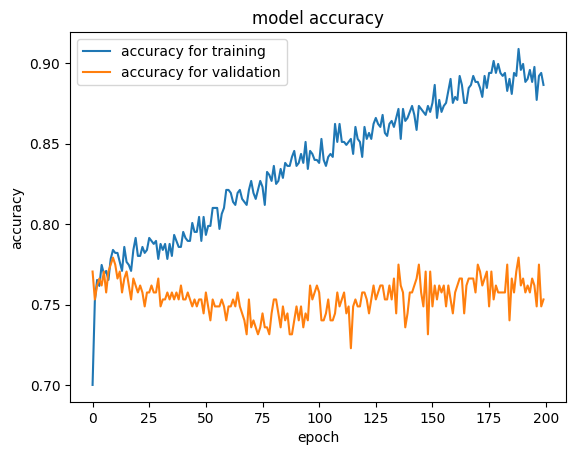

In [47]:
plot_history_acc(hist)

### DNNの多クラス分類器

#### データ

##### 生成
[クラス分類器](ScikitLearnTraining3.ipynb)で使用したデータを使用。

In [48]:
iris = datasets.load_iris()
df_data = pd.DataFrame(iris.data, columns=iris.feature_names)
df_target = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([df_data, df_target], axis=1)

##### 加工
...

##### 理解
...

##### 準備

###### 説明変数・目的変数の選択・分割

In [49]:
np_arr=np.array(df)

# n = 100で2値分類
# n = 150で3値分類
n = 150

# PetalLengthCm, PetalWidthCm列の選択
#x=np_arr[:n, 2:4] 
# 全列の選択
x=np_arr[:n, 0:4] 

# Species列の選択
y=np.array(np_arr[:n, 4:5],dtype=np.int64) # 要素の型をint64に変換

###### 標準化
カテゴリ・データは対象外

In [50]:
ss = StandardScaler()
ss.fit(x)
x_std = ss.transform(x)

###### one-hotエンコーディング
Keras（≒ 深層学習）では正解ラベルはOne-Hotベクトル化が必要。

In [51]:
yy = to_categorical(y)

###### 学習・テストデータの分割

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x_std, yy, test_size=0.3, random_state=0)

#### モデリング

##### DNNの定義
- 入力層  
入力ベクトルの要素数だけ。
- 隠れ層が
  - 1つ
  - 100ノード
  - 活性化関数はrelu
- 出力層  
多クラス分類なので
  - ノードは分類の数だけ
  - 活性化関数はsoftmax

In [53]:
model = Sequential([
    Dense(100, activation=tf.nn.relu,
          input_shape=(x_train.shape[1],)),
    Dense(3, activation=tf.nn.softmax)
])

##### コンパイル
- 多値分類の損失関数は交差エントロピー（categorical_crossentropy）
- [optimizer=Adam](TensorFlowAndKeras0.ipynb)を指定する。
- metricsは正解率（accuracy）

In [54]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy'])

##### 確認

In [55]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803 (3.14 KB)

 Trainable params: 803 (3.14 KB)

 Non-trainable params: 0 (0.00 B)

#### 実行

##### 学習

In [56]:
batch_size = 10
n_epoch = 50
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=n_epoch,
                 validation_data=(x_test, y_test),
                 verbose=0)

##### 推論

In [57]:
yy_pred = model.predict(x_std)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


#### 評価

###### 実測・予測を表示

In [58]:
y_pred = np.array(yy_pred.argmax(axis=-1), dtype=np.int64)
ret = (y.flatten() == y_pred)
(len(np.where(ret==True)[0]) / ret.size)

0.9933333333333333

###### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)

In [59]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [60]:
score = model.evaluate(x_std, yy)
print('loss:', score[0])
print('accuracy:', score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0373   
loss: 0.048519305884838104
accuracy: 0.9933333396911621


In [61]:
train_score = model.evaluate(x_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0092 
Train loss: 0.010968110524117947
Train accuracy: 1.0


In [62]:
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9852 - loss: 0.0931 
Test loss: 0.13613875210285187
Test accuracy: 0.9777777791023254


###### 混同行列
間違い易い組合せが解る。

In [63]:
cm_minst = confusion_matrix(y, y_pred)
print(cm_minst.dtype)
print(cm_minst)

int64
[[50  0  0]
 [ 0 49  1]
 [ 0  0 50]]


In [64]:
print_metrics(y, y_pred)

accuracy: 0.993

micro
recall: 0.993
precision: 0.993
f1_score: 0.993

macro
recall: 0.993
precision: 0.993
f1_score: 0.993


###### 学習履歴を表示

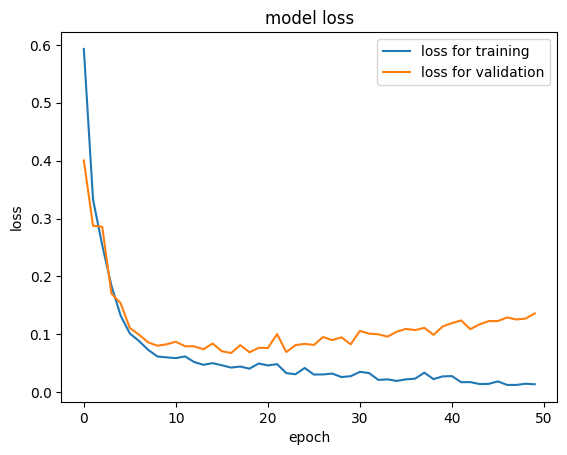

In [65]:
plot_history_loss(hist)

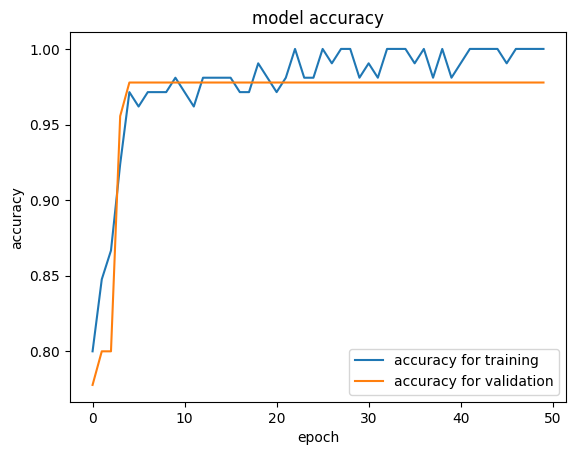

In [66]:
plot_history_acc(hist)